#  Monte Carlo Simulation

## 1. 몬테카를로 시뮬레이션의 정의

몬테카를로 시뮬레이션이란, 통계학에서 사용되는 큰 수의 법칙을 금융에 이용한 것입니다.
파생상품뿐만이 아닌 모든 자산의 가격은 다음 식을 만족합니다.

$$ P_t = e^{-r(T-t)}E(CF_T) $$

이때 $P_t$는 자산의 현재 가격, $CF_T$는 만기 시점에서의 현금흐름입니다. 또 $t$는 현재 시점을, $T$는 만기 시점을 나타냅니다 <br>
즉, 만기 시점에서의 현금흐름의 기댓값을 현재가치화한 것이 자산의 가격입니다.<br>
하지만 현금흐름의 기댓값을 수학적으로 구하기 어렵다는 것이 가격결정의 가장 큰 문제점입니다.<br>
몬테카를로 시뮬레이션은 이 문제를 큰 수의 법칙을 이용해 해결합니다.
큰 수의 법칙은 다음과 같습니다

If $N$ is big,
$$ E(X) \approx {{(X_1 + X_2 + X_3 + ...+ X_N)}\over N} $$

몬테카를로 시뮬레이션은 이를 이용해, 현재 알고 있는 주가의 분포를 활용해 가능한 주가 시나리오를 최대한 많이 제작하여,<br> 만기 시점에서의 현금흐름의 평균을 구해 현재가치화하는 방법으로 금융상품의 적정가치를 계산합니다.

## 2. 기본적인 몬테카를로 시뮬레이션

이제 지난 강의에서 언급된 GBM과 바닐라 옵션의 payoff를 이용해 주가가 로그 정규분포를 따를 때의 바닐라 콜옵션의 가격을 구해 보겠습니다.

GBM을 따르는 주가는 다음 확률과정을 따릅니다.<br>
$$ {dS \over S}  = rdt + \sigma dW $$
이때 $r$은 무위험이자율, $\sigma$는 주가의 $dt$시간 동안의 변동성, $dW$는 표준정규분포를 따르는 확률변수입니다. <br>
즉 이 식에서 시나리오를 제작해야 하는 불확실한 과정, 즉 확률과정은 $dW$ 뿐이므로, $dW$의 시나리오를 제작하여 위 식에 대입하면 주가의 시나리오를 제작할 수 있습니다

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy
from scipy.stats import norm

In [2]:
N = norm.cdf
def CallOptionBS(S, K, T, r, q, sigma):
    if T == 0.0:
        return np.maximum(S - K, 0)
    else:
        d1 = (np.log(S / K) + (r - q + sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        return S * np.exp(-q * T) * N(d1) - K * np.exp(-r * T) * N(d2)

시작 가정으로 현재 주가는 100, 연속 배당률은 0, 연속 무위험 이자율은 2%, 주가의 변동성은 20%, 만기는 1년이며, 이는 250일의 영업일로 이루어진 것으로 가정합니다. 그리고 시뮬레이션의 횟수는 10000번으로 설정합니다.

In [3]:
s0 = 100
q = 0
r = 0.02
sigma = 0.2
T = 1
days = 250
nsimulation = 10000

그러면 표준 정규분포의 시나리오는 250일간의 시나리오가 총 10000번 제작되니 총합 250만 개 제작됩니다.<br>
편의를 위해 250×10000 행렬로 제작하겠습니다.

In [4]:
Normal = np.random.normal(size=(T*days, nsimulation))

주가가 250일동안 변하니 주가의 시나리오는 시작일을 포함해 총 251일간의 시나리오가 됩니다.

In [5]:
path = np.zeros((T*days+1,nsimulation))
path[0] = s0

변화한 주가 $S+ds$는 다음과 같습니다<br>
$$S+ds = S(1+{dS\over S}) = S(1+rdt+\sigma_{dt} dW)$$
이때 $\sigma_{dt}$는 짧은 시간 $dt$동안의 주가의 변동성으로 1년동안의 주가의 변동성 $\sigma$와 다음의 관계를 가집니다.<br>
$$\sigma_{dt} = \sigma \sqrt {dt}$$
이제 $dW$ 시나리오를 토대로 $rdt+\sigma_{dt} dW$ 시나리오를 만듭니다

In [6]:
dt = 1/250
logds = r*dt + Normal * sigma*np.sqrt(dt)

이제 만든 시나리오를 이용해 주가 시나리오를 완성합니다

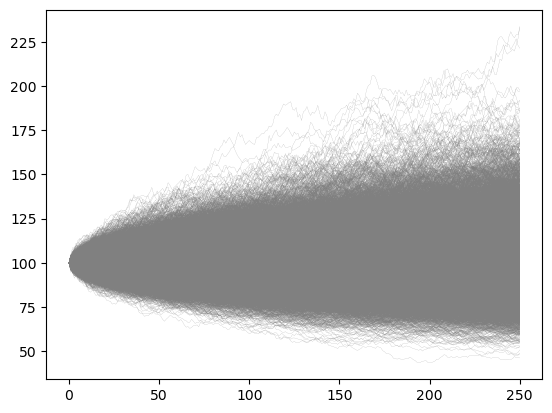

In [7]:
for i in range(1,T*days+1):
    path[i] = path[i-1]*(1+logds[i-1])
plt.plot(path,color = "gray",linewidth = "0.1")
plt.show()

이제 콜옵션의 행사가격 $K$를 100으로 지정하고, 콜옵션의 payoff인 $max(S-K,0)$를 각 시나리오의 만기에 적용시켜 평균을 구하고 현재가치로 할인하여 콜옵션의 적정가격을 구할 수 있습니다

In [8]:
np.mean(np.maximum(path[-1]-100,0))*np.exp(-r*T)

8.902910939928462

수학적으로 계산한 콜옵션 가격과 비교했을 때, 높은 정확도를 보이는 것을 알 수 있습니다.

In [9]:
CallOptionBS(s0, 100, T, r, q, sigma)

8.916037278572539

### Exercise 1. 주어진 조건을 바탕으로 유로피안 풋 옵션의 가격을 몬테 카를로 시뮬레이션을 바탕으로 계산한 뒤, 이를 Close form solution과 비교해봅시다.

In [10]:
s0 = 100
q = 0
r = 0.02
sigma = 0.2
T = 1
days = 250
nsimulation = 100000
K=100

In [11]:
N = norm.cdf
def PutOptionBS(S, K, T, r, q, sigma):
    if T == 0.0:
        return np.maximum(S - K, 0)
    else:
        d1 = (np.log(S / K) + (r - q + sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        call_f= S * np.exp(-q * T) * N(d1) - K * np.exp(-r * T) * N(d2)
        put_f= call_f + K*np.exp(-r*T)-S
        return put_f

In [12]:
Normal = np.random.normal(size=(T*days, nsimulation))

path = np.zeros((T*days+1,nsimulation))
path[0] = s0

dt = 1/250
logds = r*dt + Normal * sigma*np.sqrt(dt)

for i in range(1,T*days+1):
    path[i] = path[i-1]*(1+logds[i-1])

np.mean(np.maximum(K-path[-1],0))*np.exp(-r*T)

6.8788752428099045

In [13]:
PutOptionBS(s0, K, T, r, q, sigma)

6.93590460924807

### Exercise 2. 풋 옵션에서 변동성 시그마가 0.2일때와 0.1일때 옵션 가격을 블랙 숄즈 방정식을 이용해 계산하고 그래프를 통해 시각화하시오

In [14]:
# 이 함수를 이용해서 계산하시면 됩니다

def CallOptionBS(S, K, T, r, q, sigma):
    if T == 0.0:
        return np.maximum(S - K, 0)
    else:
        d1 = (np.log(S / K) + (r - q + sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        return S * np.exp(-q * T) * N(d1) - K * np.exp(-r * T) * N(d2)

In [15]:
def PutOptionBS(S, K, T, r, q, sigma):
    if T == 0.0:
        return np.maximum(S - K, 0)
    else:
        d1 = (np.log(S / K) + (r - q + sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        call_f= S * np.exp(-q * T) * N(d1) - K * np.exp(-r * T) * N(d2)
        put_f= call_f + K*np.exp(-r*T)-S
        return put_f

[]

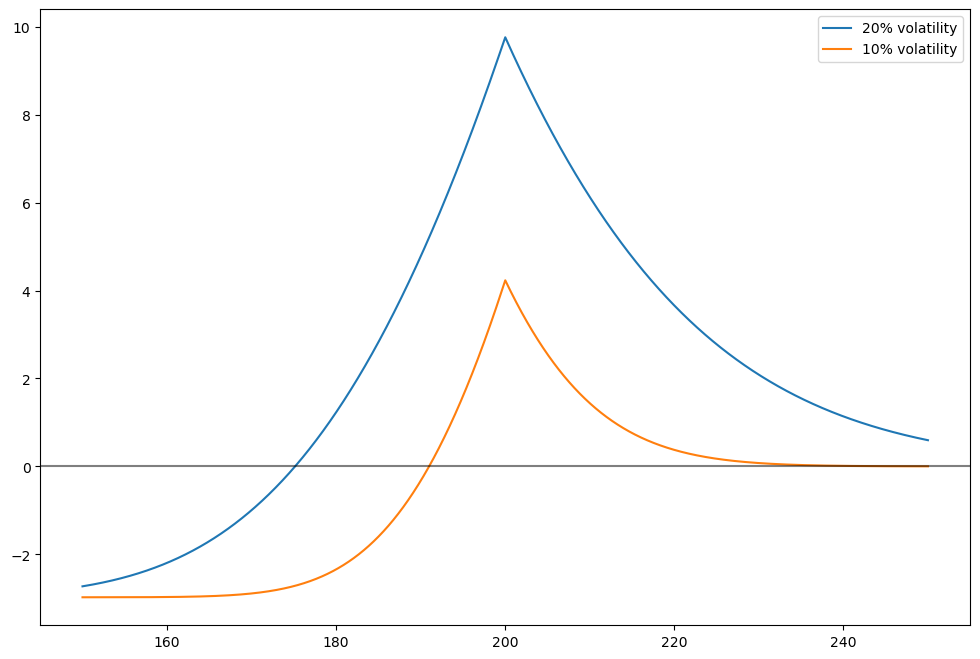

In [16]:
import numpy as np
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt

put_tv_20=[]
for s in np.linspace(150, 250, 10000):
    put_tv_20.append([s, PutOptionBS(s, 200, 0.5, 0.03, 0, 0.2)-max(200-s,0)])
df_20=pd.DataFrame(put_tv_20)

put_tv_10=[]
for s in np.linspace(150, 250, 10000):
    put_tv_10.append([s, PutOptionBS(s, 200, 0.5, 0.03, 0, 0.1)-max(200-s,0)])
df_10=pd.DataFrame(put_tv_10)

plt.figure(figsize=(12,8))
plt.plot(df_20[0], df_20[1], label='20% volatility')
plt.plot(df_10[0], df_10[1], label='10% volatility')
plt.axhline(alpha=0.5, color='black')
plt.legend()
plt.plot()